 Dataset Loaded Successfully!
Shape: (1829, 11)
Columns: ['Id', 'Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome', 'Age_Binned']

=== Default Random Forest Performance ===
Accuracy:  0.9891
Precision: 0.9919
Recall:    0.9762
F1 Score:  0.9840
Fitting 5 folds for each of 216 candidates, totalling 1080 fits

  Best Parameters Found:
{'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

=== Tuned Random Forest Performance ===
Accuracy:  0.9891
Precision: 0.9919
Recall:    0.9762
F1 Score:  0.9840
AUC Score: 0.9998


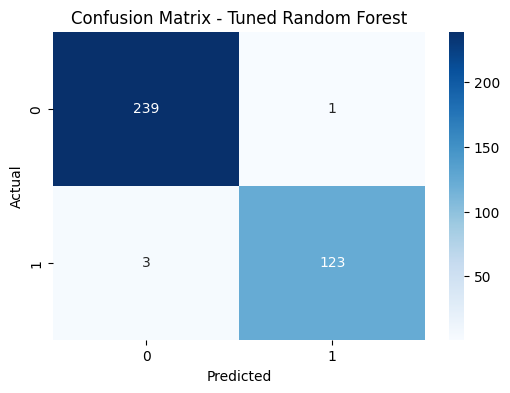

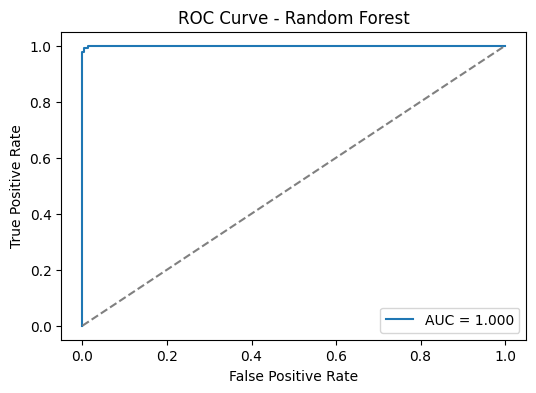


Cross-Validation Accuracy Scores: [0.97540984 1.         1.         1.         1.        ]
Mean CV Accuracy: 0.9950819672131146


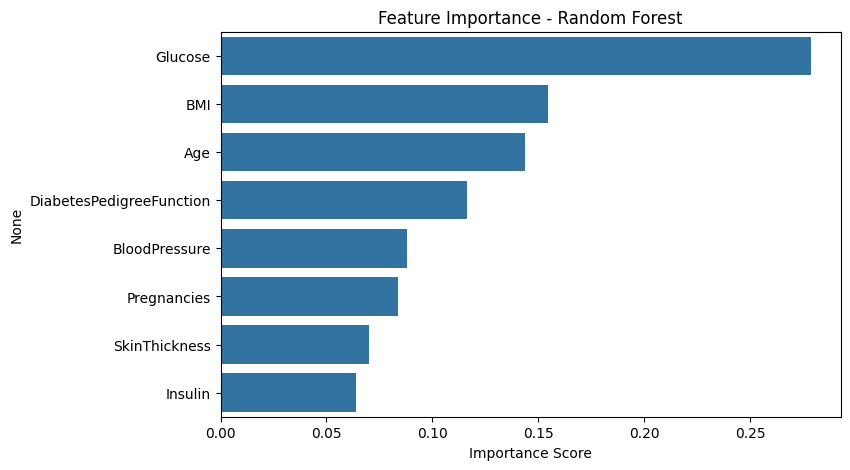


  Model saved successfully at: best_random_forest_model.pkl


In [1]:
# ================================================================
# Random Forest Classifier Model
# ================================================================

# -------------------------------
# 1. Import Required Libraries
# -------------------------------
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import (
    train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
)
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, roc_auc_score,
    roc_curve, classification_report
)
import joblib

# -------------------------------
# 2. Load Dataset
# -------------------------------
CSV_PATH = "final_preprocessed.csv"

if not os.path.exists(CSV_PATH):
    raise FileNotFoundError(f"Dataset not found at {CSV_PATH}")

data = pd.read_csv(CSV_PATH)
print(" Dataset Loaded Successfully!")
print("Shape:", data.shape)
print("Columns:", data.columns.tolist())

# Identify target column (edit as needed)
target_col = "Outcome" if "Outcome" in data.columns else "__y__"

# Drop unnecessary columns
drop_cols = ['Id', 'Age_Binned', target_col] if 'Age_Binned' in data.columns else ['Id', target_col]
X = data.drop(columns=drop_cols, errors='ignore')
y = data[target_col]

# -------------------------------
# 3. Data Splitting and Scaling
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# -------------------------------
# 4. Baseline Random Forest Model
# -------------------------------
rf_default = RandomForestClassifier(random_state=42)
rf_default.fit(X_train_scaled, y_train)
y_pred_default = rf_default.predict(X_test_scaled)

print("\n=== Default Random Forest Performance ===")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_default):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_default):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_default):.4f}")
print(f"F1 Score:  {f1_score(y_test, y_pred_default):.4f}")

# -------------------------------
# 5. Hyperparameter Tuning
# -------------------------------
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [4, 6, 8, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    scoring='accuracy',
    n_jobs=-1,
    cv=cv,
    verbose=1
)

grid_search.fit(X_train_scaled, y_train)
best_rf = grid_search.best_estimator_

print("\n  Best Parameters Found:")
print(grid_search.best_params_)

# -------------------------------
# 6. Evaluate Tuned Model
# -------------------------------
y_pred_best = best_rf.predict(X_test_scaled)
y_prob_best = best_rf.predict_proba(X_test_scaled)[:, 1]

acc = accuracy_score(y_test, y_pred_best)
prec = precision_score(y_test, y_pred_best)
rec = recall_score(y_test, y_pred_best)
f1 = f1_score(y_test, y_pred_best)
auc = roc_auc_score(y_test, y_prob_best)

print("\n=== Tuned Random Forest Performance ===")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"AUC Score: {auc:.4f}")

# -------------------------------
# 7. Confusion Matrix
# -------------------------------
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Tuned Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# -------------------------------
# 8. ROC Curve
# -------------------------------
fpr, tpr, thresholds = roc_curve(y_test, y_prob_best)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend()
plt.show()

# -------------------------------
# 9. Cross-Validation
# -------------------------------
cv_scores = cross_val_score(best_rf, X, y, cv=5, scoring='accuracy')
print("\nCross-Validation Accuracy Scores:", cv_scores)
print("Mean CV Accuracy:", np.mean(cv_scores))

# -------------------------------
# 10. Feature Importance
# -------------------------------
importances = pd.Series(best_rf.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(8, 5))
sns.barplot(x=importances, y=importances.index)
plt.title("Feature Importance - Random Forest")
plt.xlabel("Importance Score")
plt.show()

# -------------------------------
# 11. Save Model
# -------------------------------
MODEL_PATH = "best_random_forest_model.pkl"
joblib.dump(best_rf, MODEL_PATH)
print(f"\n  Model saved successfully at: {MODEL_PATH}")
